In [104]:
import os
import pickle
import multiprocessing
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, FastICA

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_predict

color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 100

from subprocess import check_output

from pyfm import pylibfm
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 19.5 ms


In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

train['test'] = 0
test['test'] = 1

df = pd.concat([train, test], axis=0)
y = train.y
df = df.drop(["ID", "y"], axis=1)
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

ix_train = df.test == 0
ix_test = df.test == 1

Train shape :  (4209, 379)
Test shape :  (4209, 378)
time: 827 ms


In [105]:
for col in feat_categ:
    df[col] = LabelEncoder().fit_transform(df[col])
X = OneHotEncoder().fit_transform(df[feat_categ])

feat_ohe = ['ohe_' + str(i) for i in np.arange(X.shape[1])]
t = pd.DataFrame(X.todense(), columns=feat_ohe, index=df.index)
df = pd.concat( [df, t] , axis=1)

time: 162 ms


In [3]:
def pickle_check_model(predictors, model_file, bremove = False):
    model_file = './../tmp/' + model_file
    if bremove and os.path.isfile(model_file):
        print("Removing old file")
        os.remove(model_file)
    if not os.path.isfile(model_file):
        print("Make grid search...")
        model = check_model(predictors)

        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
    else:
        with open(model_file, 'rb') as f:
            print("Load from file...")
            model = pickle.load(f)
    print(model.best_score_)
    print(model.best_params_)
    return model

time: 14.6 ms


In [5]:
feat_all = train.columns[2:]
feat_categ = train.dtypes.index[train.dtypes == 'object']
feat_numb = list(set(feat_all) - set(feat_categ))

time: 23.2 ms


In [6]:
t = pickle_check_model(feat_numb, '4_model.pkl', bremove=False)

Load from file...
0.511579804396
{'en__alpha': 1e-05, 'en__l1_ratio': 1}
time: 31.8 ms


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


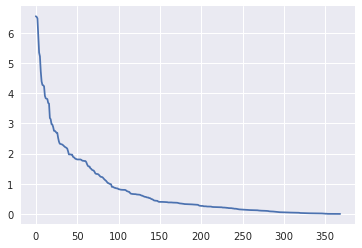

time: 212 ms


In [25]:
a = t.best_estimator_.steps[0][1]
df_tmp = pd.DataFrame({'col':feat_numb, 'val':a.coef_})
df_tmp['abs_val'] = np.abs(df_tmp.val)
df_tmp = df_tmp.sort_values('abs_val', ascending=False).reset_index()
plt.plot(df_tmp.abs_val)
feat_numb_top150 =list(df_tmp.col[:150])
feat_numb_top200 =list(df_tmp.col[:200])

In [152]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def one_model_pred(f_predict, columns = None, out_file_name=None):
    if columns is None:
        raise Exception("Col is None")
    if out_file_name is None:
        raise Exception("out_file_name is None")
    X_stacking = np.empty(df.shape[0])
    X = df[ix_train]; print(X.shape)
    i = 0
    for train_index, test_index in kf.split(X):
        i = i + 1
        print("Fold=",i)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_pred = f_predict(X_train, y_train, X_test, columns)
        X_stacking[test_index] = y_pred
        print(r2_score(y_test, y_pred))
    print("KFold done!")
    X_stacking[ix_test] = xgb_fit(df[ix_train], y, df[ix_test], feat_numb_top200)
    pd.DataFrame({'y_pred':X_stacking}).\
        to_csv("../y_pred/" + out_file_name + ".csv", index=False)
    print("Done!")
    return None

time: 17 ms


In [153]:
def xgb_fit(X_train, y_train, X_test, columns = None):
    if columns is None:
        raise Exception("Col are None")
    num_boost_rounds = 1200
    
    xgb_params = { 
        'eta': 0.005,
        'max_depth': 4,
        'subsample': 0.8,
        'min_child_weight': 25,
        'colsample_bytree': 0.8,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'base_score': np.mean(y_train), # base prediction = mean(target)
        'silent': 1,
        'tree_method':'hist',
        'seed':42,
    #    'gamma': 0.05,
        'alpha':0.3
    }

    dtrain = xgb.DMatrix(X_train[columns], y_train)
    dtest = xgb.DMatrix(X_test[columns])
    
    
    # train model
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
    y_pred = model.predict(dtest)
    return y_pred
    

time: 12 ms


In [154]:
if not os.path.isfile('./../tmp/model_score_list.pkl'):
    with open('./../tmp/model_score_list.pkl', 'wb') as f:
        pickle.dump(model_score_list, f)
    with open('./../tmp/model_pairs_list.pkl', 'wb') as f:
        pickle.dump(model_pairs_list, f)
else:
    with open('./../tmp/model_pairs_list.pkl', 'rb') as f:
        print("Load from file...")
        model_pairs_list = pickle.load(f)
    with open('./../tmp/model_score_list.pkl', 'rb') as f:
        print("Load from file...")
        model_score_list = pickle.load(f)
       

Load from file...
Load from file...
time: 9.25 ms


In [155]:
def woker_split(p_in):
    p = p_in.split("_")
    f1 = p[0]
    f2 = p[1]
    df[p_in] = df[f1] * df[f2]
    return p_in
df_tmp = pd.DataFrame({'scr':model_score_list}) 
top_index = df_tmp.sort_values('scr', ascending=False).\
      head(5).index
#for pairs_index in 
#_ = [woker_split(p) for p in model_pairs_list[pairs_index]]

feat_pairs_in_top = sum([model_pairs_list[ind] for ind in top_index], [])
feat_pairs_in_top = list(set(feat_pairs_in_top))

# Add pairs to train
_ = [woker_split(p) for p in feat_pairs_in_top]

time: 555 ms


In [156]:
one_model_pred(xgb_fit, feat_numb_top200, 'xgb_feat_numb_top200_XGB2')

(4209, 1999)
Fold= 1
0.582834199884
Fold= 2
0.429843661236
Fold= 3
0.601297376514
Fold= 4
0.613641290205
Fold= 5
0.597170866205
KFold done!
Done!
time: 13.2 s


In [157]:
one_model_pred(xgb_fit, feat_numb, 'xgb_feat_numb_XGB')

(4209, 1999)
Fold= 1
0.588035735666
Fold= 2
0.439067713113
Fold= 3
0.599509297869
Fold= 4
0.614879228576
Fold= 5
0.594274932349
KFold done!
Done!
time: 19.3 s


In [158]:
def sgd_fit(X_train, y_train, X_test, columns = None):
    if columns is None:
        raise Exception("Col are None")
    
    classifier = lambda: SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=1e-05,
        l1_ratio=1,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)
    
    clf = Pipeline(steps=[
        #('ss', StandardScaler()),
        ('en', classifier())
    ])
    clf.fit(X_train[columns], y_train)
    y_pred = clf.predict(X_test[columns])
    return y_pred
one_model_pred(sgd_fit, feat_numb + feat_pairs_in_top, 'sgd_feat_numb_pairs')
one_model_pred(sgd_fit, feat_numb_top200 + feat_pairs_in_top, 'sgd_feat_numb200_pairs')
one_model_pred(sgd_fit, feat_numb_top150 + feat_pairs_in_top, 'sgd_feat_numb150_150pairs')

(4209, 1999)
Fold= 1
0.5396535616
Fold= 2
0.38690821244
Fold= 3
0.551612469892
Fold= 4
0.571315124741
Fold= 5
0.533747988487
KFold done!
Done!
(4209, 1999)
Fold= 1
0.527393762312
Fold= 2
0.380350231047
Fold= 3
0.536722460224
Fold= 4
0.555330928589
Fold= 5
0.510047934234
KFold done!
Done!
(4209, 1999)
Fold= 1
0.51362689895
Fold= 2
0.367232416859
Fold= 3
0.520540604849
Fold= 4
0.535956709892
Fold= 5
0.476461107259
KFold done!
Done!
time: 11.9 s


In [159]:
feat_list = feat_numb_top150 + feat_pairs_in_top
n_comp = 10


# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca.fit(df[ix_train][feat_list])
pca2_df = pca.transform(df[feat_list])

# ICA
ica = FastICA(n_components=n_comp, random_state=42, max_iter = 600)
ica.fit(df[ix_train][feat_list])
ica2_df= ica.transform(df[feat_list])

# Append decomposition components to datasets
feat_pca = list()
feat_ica = list()
for i in range(1, n_comp+1):
    df['pca_' + str(i)] = pca2_df[:,i-1]
    df['ica_' + str(i)] = ica2_df[:,i-1]
    feat_pca.append('pca_' + str(i))
    feat_ica.append('ica_' + str(i))

time: 4.16 s


In [160]:
one_model_pred(xgb_fit, feat_pca + feat_ica + feat_numb, 'xgb_feat_numb_ica_pca')

(4209, 1999)
Fold= 1
0.592088308183
Fold= 2
0.441478003324
Fold= 3
0.602194524246
Fold= 4
0.611307452647
Fold= 5
0.586884992204
KFold done!
Done!
time: 29.3 s


In [161]:
one_model_pred(xgb_fit, feat_ohe + feat_ica + feat_pca, 'xgb_feat_numb_ica_pca')
one_model_pred(xgb_fit, feat_ica + feat_pca, 'feat_ica + feat_pca')
one_model_pred(xgb_fit, feat_ohe + feat_numb_top200, 'feat_ohe + feat_numb_top200')
one_model_pred(xgb_fit, feat_ohe + feat_pairs_in_top, 'feat_ohe + feat_pairs_in_top')

(4209, 1999)
Fold= 1
0.528798060171
Fold= 2
0.389495196404
Fold= 3
0.537906726404
Fold= 4
0.562850557457
Fold= 5
0.52902148063
KFold done!
Done!
(4209, 1999)
Fold= 1
0.45567063555
Fold= 2
0.348407034099
Fold= 3
0.489996177396
Fold= 4
0.507521009871
Fold= 5
0.46032357257
KFold done!
Done!
(4209, 1999)
Fold= 1
0.588741341902
Fold= 2
0.432715852498
Fold= 3
0.603936140869
Fold= 4
0.611924140335
Fold= 5
0.594546204005
KFold done!
Done!
(4209, 1999)
Fold= 1
0.54371351403
Fold= 2
0.399161241007
Fold= 3
0.551923154354
Fold= 4
0.566412557453
Fold= 5
0.551010874261
KFold done!
Done!
time: 2min 4s


In [162]:
files = list(os.listdir('../y_pred'))
X = np.empty((df.shape[0],len(files)))
i = 0
for filename in files:
    X[:,i] = np.loadtxt('../y_pred/'+filename,skiprows=1)
    i = i + 1
X = StandardScaler().fit_transform(X)
    
from sklearn.linear_model import LinearRegression
#model = #LinearRegression()
model = SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=0.001,
        l1_ratio=1,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)

model.fit(X[ix_train], y)
y_sumbit = model.predict(X[ix_test])

pd.DataFrame({'ID':test.ID, 'y':y_sumbit}).to_csv("../submit/stacking_by_SGD_10folds.csv", index=False)

time: 656 ms


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


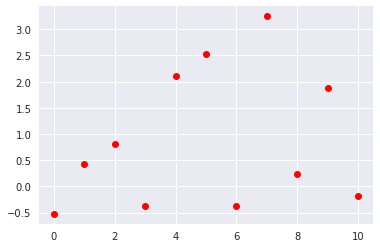

time: 231 ms


In [163]:
plt.plot(model.coef_, 'ro')